In [40]:
import torch
import torchvision #since the dataset involves images
import torch.nn as nn #neural network module
import torch.nn.functional as F #functions for neural networks  like loss functions
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split #to load data in batches and shuffle on requirement


In [41]:
################# CIFAR10 dataset #################

data_statistics = ((0.5,0.5,0.5),(0.5,0.5,0.5)) #mean and standard deviation of the dataset the thre represents the number of channels in the image that is RGB
train_tranforms_cifar = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'), #randomly crop the image to 32x32
    transforms.RandomHorizontalFlip(), #randomly flip the image horizontally
    transforms.ToTensor(), #converts the image to a tensor C x H x W
    transforms.Normalize(*data_statistics,inplace=True) #normalizes the image now image is in the range [-1,1], data = (data-mean)/std
])
test_tranforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics,inplace=True)
])
dataset= torchvision.datasets.CIFAR10(root='data/',download=True,transform=train_tranforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root='data/',download=True,train=False,transform=test_tranforms_cifar) #test dataset no transformation required for test images

Files already downloaded and verified
Files already downloaded and verified


In [42]:
#####################splitting the dataset into training and validation dataset#####################

val_ratio = 0.2 #ratio of validation dataset
train_dataset, val_dataset = random_split(dataset,[int((1-val_ratio)*len(dataset)),int(val_ratio*len(dataset))]) #split the dataset into training and validation dataset
batch_size= 64 # usually the entire dataset is not loaded at once, it is loaded in batches beacuse of its very large size, and smaller batches helps it to learn often and better generalisation and good enough local minima
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,pin_memory= True) #shuffle is used to shuffle the data in each epoch
#pin memory is used to load the data in the GPU memory directly, it is faster than loading it in the CPU memory and then transferring it to the GPU memory
val_dl = DataLoader(val_dataset,batch_size,shuffle=True,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size,pin_memory=True)

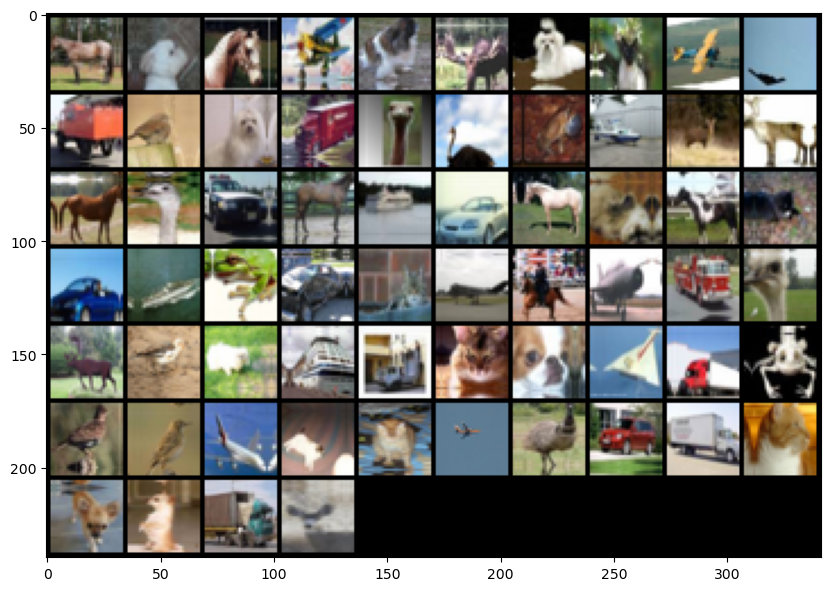

In [43]:
#############################################Visualizing the dataset##############################################

def denormalize(images,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds + means

def show_batch(dl):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(10,10))
        images= denormalize(images,*data_statistics)
        ax.imshow(make_grid(images,nrow=10).permute(1,2,0)) #H x W x C permute to rearrange the dimensions
        break
show_batch(train_dl)

In [44]:
##############Data Loader for GPU################

def get_default_device(): # to get the device on which the model is running
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(entity, device):
    if isinstance(entity, (list,tuple)):
        return [to_device(e,device) for e in entity]
    return entity.to(device,non_blocking=True) #non_blocking is used to load the data in the GPU memory asynchronously

class DeviceDataLoader():
    # wrapper around data loader to move the data to the device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch,self.device)
    
    def __len__(self):
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

In [45]:
##############Network Architecture################
# why is a CNN network used for image classification?
# CNN is used for image classification because of the following reasons:
# 1. CNN is used for image classification because of its ability to capture spatial hierarchies in the image
# 2. CNN uses filters to extract features from the image, these filters are learned during the training process
# 3. CNN uses pooling to reduce the spatial dimensions of the image, this helps in reducing the number of parameters and computation
# 4. CNN uses multiple layers of filters to capture complex patterns in the image
# 5. CNN uses non-linear activation functions like ReLU to introduce non-linearity in the model
# 6. CNN uses dropout to prevent overfitting
from collections import OrderedDict

def conv_block(in_channels, out_channels, pool = False):
    layers= [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResnetX(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1= conv_block(in_channels,64)
        self.conv2= conv_block(64,128,pool=True)
        self.res1 =  nn.Sequential(OrderedDict([("conv1res1",conv_block(128,128)),("conv2res1",conv_block(128,128))]))

        self.conv3= conv_block(128,256,pool=True)
        self.conv4= conv_block(256,512,pool=True)
        self.res2 =  nn.Sequential(conv_block(512,512),conv_block(512,512))
        self.classifier = nn.Sequential(nn.MaxPool2d(4), #global average pooling
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes))
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        return self.classifier(out)

In [46]:
model= ResnetX(3,10)
model 
[x.shape for x in model.res1.parameters()]

[torch.Size([128, 128, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 128, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128])]

In [47]:
##############Training the model################

def accuracy(outputs,labels):
    pred,predClassId = torch.max(outputs,dim=1) # find the maximum value in the output tensor and the index of the maximum value
    return torch.tensor(torch.sum(predClassId == labels).item()/len(outputs)) # calculate the accuracy by comparing the predicted class id with the actual class id

def evaluate(model, val_dl,loss_func):
    model.eval()
    batch_losses, batch_accs = [],[]
    for image, labels in val_dl: #iterate over each batch of the validation dataset
        with torch.no_grad(): #no need to calculate the gradients
            logits = model(image) #forward pass
        batch_losses.append(loss_func(logits,labels)) #append the loss to the list of losses
        batch_accs.append(accuracy(logits,labels)) #append the accuracy to the list of accuracies
    epoch_avg_loss = torch.stack(batch_losses).mean().item() #calculate the average loss
    epoch_avg_acc = torch.stack(batch_accs).mean() #calculate the average accuracy for the epoch which contains the average loss and accuracy for each batch
    return epoch_avg_loss, epoch_avg_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim):
    optimizer= optim(model.parameters(),max_lr) #optimizer is used to update the weights of the model for the passed parameters
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs*len(train_dl)) #scheduler is used to update the learning rate of the optimizer, 
    #OneCycleLR is used to update the learning rate in a cyclic manner, it increases the learning rate in the first half of the epochs and then decreases it in the second half
    # epochs*(len(train_dl)) is the total number of iterations in one epoch
    results=[] 
    # lrs=[]
    for epoch in range(epochs):
        model.train() #set the model to training mode
        train_losses = [] 
        lrs = []
        for image,labels in train_dl: #iterate over each batch of the training dataset
            logits= model(image) #forward pass
            loss= loss_func(logits,labels) #calculate the loss
            train_losses.append(loss) #append the loss to the list of losses
            loss.backward() #backpropagation
            optimizer.step() #update the weights of the model
            optimizer.zero_grad() #zero the gradients
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step() #update the learning rate
        epoch_train_loss = torch.stack(train_losses).mean().item() #calculate the average loss for the epoch 
        epoch_avg_loss, epoch_avg_acc = evaluate(model,val_dl,loss_func) #evaluate the model on the validation dataset
        results.append({'avg_valid_loss':epoch_avg_loss,'avg_valid_acc':epoch_avg_acc,'avg_train_loss':epoch_train_loss,'lr': lrs}) #append the results to the list of results
    return results


In [48]:
model = to_device(model,device)
epochs = 2 
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

In [49]:
%%time
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim)
for result in results:
    print(result["avg_valid_acc"])

: 

In [ ]:
def plot(results,pairs):
    import matplotlib.pyplot as plt
    fig,axes = plt.subplots(len(pairs),figsize=(10,10))
    for i, pair in enumerate(pairs):
        for title,graphs in pair.items():
            axes[i].set_title=title
            axes[i].legend = graphs
            for graph in graphs:
                axes[i].plot([results[graph] for result in results],'-x')
            
           

plot(results, [{"Accuracies vs Epochs":["avg_valid_acc"]},{"Losses vs Epochs":["avg_train_loss","avg_valid_loss"]},{"Learning Rate vs Batch":["lrs"]}])

In [ ]:
_,test_acc = evaluate(model,test_dl,loss_func)
print(test_acc)

torch.save(model.state_dict(),'cifar10-resnet9.pth')
model2 = ResnetX(3,10)
_,test_acc = evaluate(model2,test_dl,loss_func)
print(test_acc)

model2.load_state_dict(torch.load('cifar10-resnet9.pth'))
_,test_acc = evaluate(model2,test_dl,loss_func)
print(test_acc)